# H&M Personalised Fashion Recommender

Part 1: Exploratory Data Analysis <br>
Part 2: Content-Based Filtering Recommender <br>
**Part 3: Collaborative Filtering Recommender**  <br>
Part 4: Model Deployment <br>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import implicit
import nmslib
from PIL import Image
import pickle

import warnings
warnings.filterwarnings("ignore")

## Collaborative Filtering
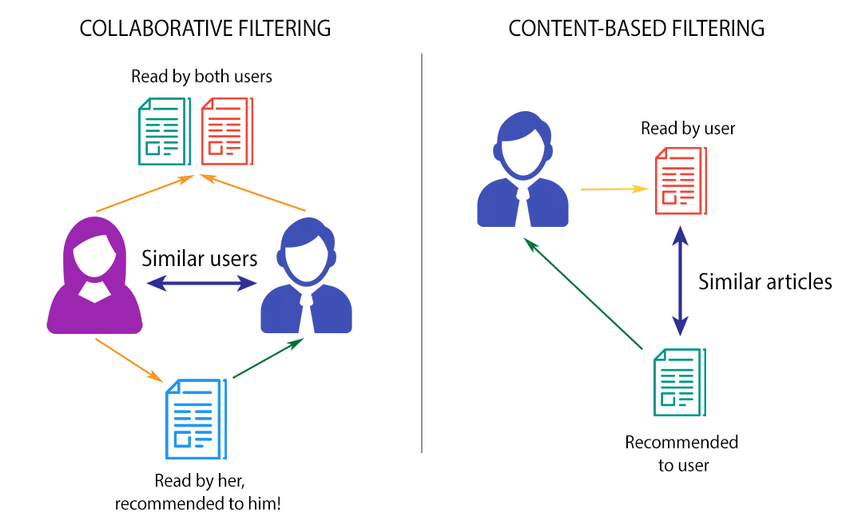

1) Content-based filtering: Find features of an item and recommend items with similar features
2) **Collaborative filtering: Recommend items based on people with similar interests** (covered in this notebook)

## Data Preprocessing

3 columns of data are needed to build a collaborative filtering recommender:
1) customer id
2) article id
3) sales data

In [2]:
transactions = pd.read_csv('../datasets/transactions.csv',usecols=['customer_id','article_id'])
print(transactions.shape)
transactions.head()

(514121, 2)


,customer_id,article_id
0,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,611415005
1,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,673677002
2,01e464bf74b13a55df22de1528eff2b33749c0cd92953b...,448515001
3,02703e242da346fc85f1aad21208d1103e62e705564c81...,629764001
4,02b50a52742b3a894cd5d1381bd3f462c3e6eff30f9dde...,639976002


In [3]:
# Get the sales data
transactions = transactions.value_counts().reset_index()
transactions.columns = ['customer_id','article_id','count']
print(transactions.shape)
transactions.head()

(383334, 3)


,customer_id,article_id,count
0,d00063b94dcb1342869d4994844a2742b5d62927f36843...,678342001,570
1,94665b46e194622ccdbcadc0170f13a2f8ede1ff6d057d...,629420001,199
2,bf996b5fba090a52b2cfe9324bdc313a3ac3b1417bf9a9...,772005005,90
3,f11ddea20db46fd5f005b6bb0ec4b083f6765d2b03e241...,557247001,86
4,1472c551f2c04873edddc853e214a033692b2b1d6ae2bb...,852521001,81


In [4]:
# Prepare customer and article id columns in a way that the model expects
transactions['customer'] = transactions['customer_id'].astype('category').cat.codes
transactions['article'] = transactions['article_id'].astype('category').cat.codes
transactions.head()

,customer_id,article_id,count,customer,article
0,d00063b94dcb1342869d4994844a2742b5d62927f36843...,678342001,570,8723,1259
1,94665b46e194622ccdbcadc0170f13a2f8ede1ff6d057d...,629420001,199,6279,729
2,bf996b5fba090a52b2cfe9324bdc313a3ac3b1417bf9a9...,772005005,90,8040,2926
3,f11ddea20db46fd5f005b6bb0ec4b083f6765d2b03e241...,557247001,86,10090,338
4,1472c551f2c04873edddc853e214a033692b2b1d6ae2bb...,852521001,81,865,3949


In [5]:
# Save the transformed 'article' column in the image dataset for later reference
image_data = pd.read_pickle('../datasets/image_embeddings.pkl')
image_data_merged = image_data.merge(transactions[['article_id','article']].drop_duplicates(), how='left', on='article_id')
image_data_merged.to_pickle('../datasets/image_embeddings_merged.pkl')

In [6]:
# Create use-item matrix
sparse_user_item = sparse.csr_matrix((transactions['count'], (transactions['customer'], transactions['article'])))

## Methodology for Collaborative Filtering
### Matrix Factorisation

Instead of using user-item matrix directly, matrix factorisation was done to reduce dimensionality and computational time.

Matrix factorisation works by multiplying two smaller matrices (user matrix and item matrix) together to approximate the original user-item matrix.

Latent features are inferred from user behaviour pattern. The matrix factorization would eventually give us how much a user is aligned with a set of latent features, and how much an item fits into this set of latent features.

An additional benefit of inferring latent features is that even if two users haven't purchased the same item, it's still possible to find the similarity between them if they share similar underlying tastes (latent features).

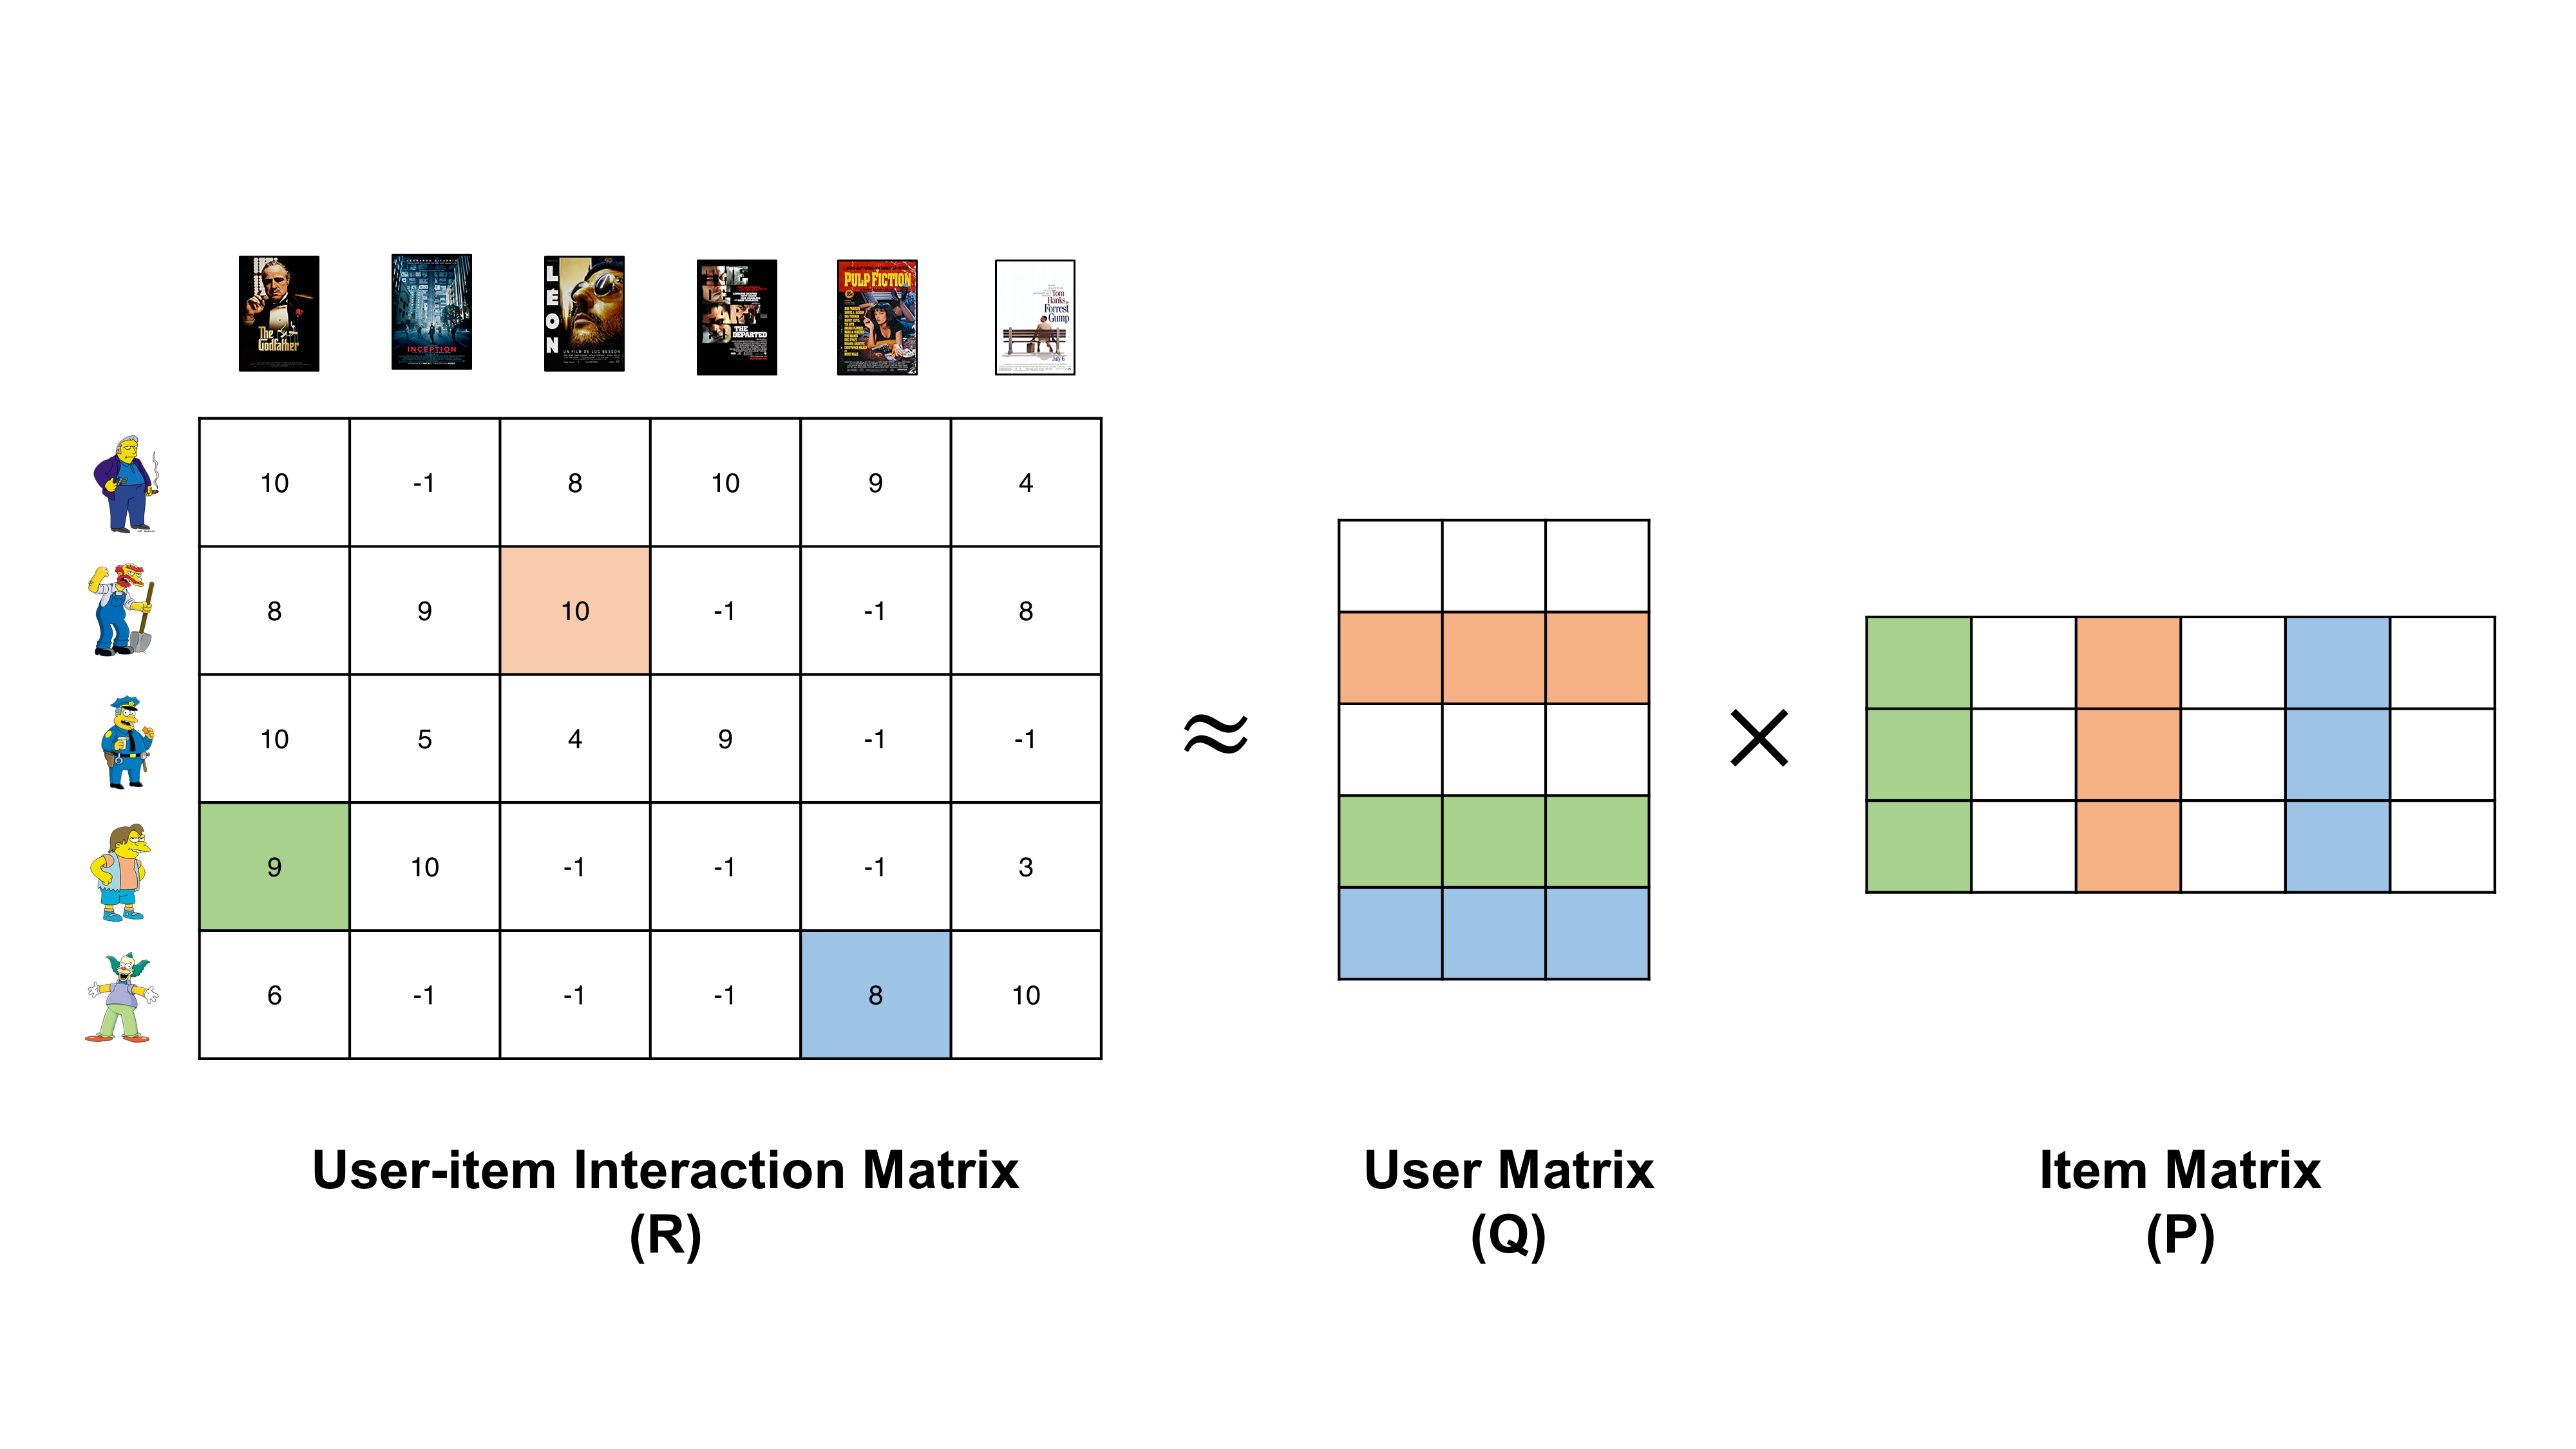

### Optimisation Algorithm for Matrix Factorisation
There are differnt ways to factorize a matrix. One way of optimising matrix factorisation is Alternating Least Square (ALS).

ALS is an iterative optimization process that tries to produce the best approximation of original matrix. 

1) 'Least Square' approach in it’s basic forms means fitting some line to the data, trying to get an optimal fit by minimising the error (sum of squared distances from all points to the line).
2) 'Alternating' means to hold user matrix constant, adjust item matrix by taking derivatives of loss function and setting it equal to 0, and then hold item matrix constant while adjusting user matrix.

The advantage of using ALS is that it's simple and it scales well to very large datasets.

### Reduce Time for Similarity Search using Hierarchical Navigable Small Worlds (HNSW)
After constructing the matrix, we will need to search through the matrix to find the most similar items/users provided a(n) item/user. An exhaustive search that searches through every single item for every single user can be computationally inefficient. 

We can reduce computational time by implementing approximate nearest neighbour search algorithm. One efficient and robust way of doing this is using Hierarchical Navigable Small Worlds (HNSW). HNSW outperforms a few other approximate nearest neighbours search algorithm in recommender task using implicit data ([source](https://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/)).

In HNSW, all the items are represented as points in a network, and the links between points represent the similarity (distance) between items. The network is a 'small-world network' because most points are not direct neighbors of one another, but most points can be reached from every other by a small number of hops.

The network has multiple hierarchical layers. The lowest layer captures all the points in the dataset, while the higher layers capture less points.

When a query comes in, the search process will start at the highest layer first, which has the least points. After finding the point nearest to the query in the highest layer, it will go one layer down and repeat the search for the nearest point. The search would terminate once the nearest points were found in the lowest layer.

The nearest neighbours found using this approach would be an approximation, because the search was not exhaustive and would end once it finds a local minimum.


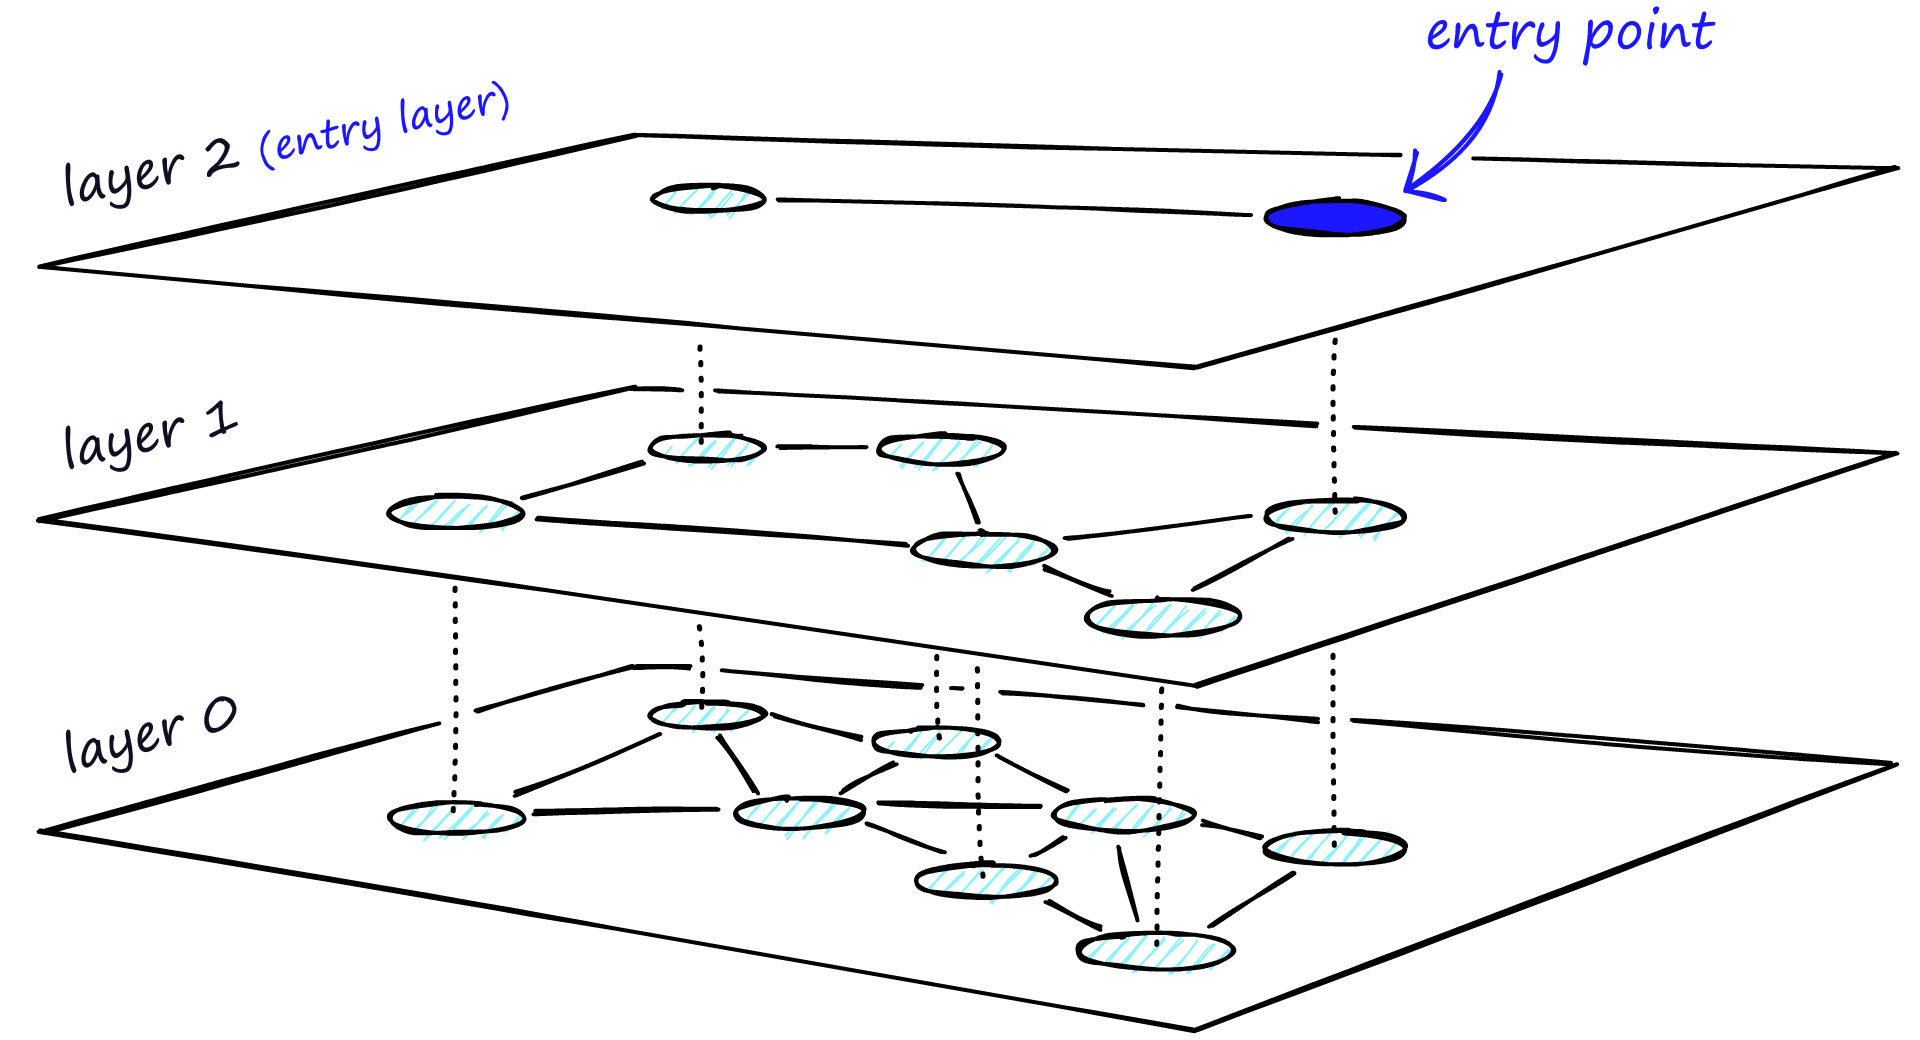
Source of Image: [link](https://www.pinecone.io/learn/hnsw/)

In [7]:
# Instantiate the model
model = implicit.approximate_als.NMSLibAlternatingLeastSquares(approximate_similar_items=True, approximate_recommend=True, method='hnsw', random_state=42)

A confidence level is applied on the matrix. Basically, present items are treated with higher confidence (i.e. when a customer bought a particular item, we are more confident that the customer likes the item), whereas unencountered items are treated with lower confidence (i.e. when a customer never buys a particular item, we are not confident that the customer dislikes the item)([source](http://yifanhu.net/PUB/cf.pdf)).

In [8]:
# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 20
data_conf = (sparse_user_item * alpha_val).astype('double')

In [9]:
# Fit the model
model.fit(data_conf, show_progress=True)

100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [10]:
# Write a function to recommend items by inputting an item index
def item_index_recommender(item_index, n_similar):
    index, score = model.similar_items(item_index, n_similar+1)
    
    # Show image of queried product
    queried_product = Image.open(image_data_merged.loc[(image_data_merged['article'] == item_index), 'img_path'].values[0]).reduce(4)
    plt.imshow(queried_product)
    plt.title("Queried Product",fontsize=20);
    plt.xticks([], [])
    plt.yticks([], []);

    # Show images of recommended product
    f, ax = plt.subplots(figsize=(20,5))
    plt.suptitle('Recommended Products',fontsize=20)

    i=1
    for idx, recommendation_score in zip(index[1:],score[1:]):
        plt.subplot(1, len(index[1:]), i)
        img = Image.open(image_data_merged.loc[image_data_merged['article'] == idx,'img_path'].values[0]).reduce(4)
        plt.imshow(img)
        plt.xlabel(f"Score: {recommendation_score:.3f}")
        plt.title(f"Article ID: {image_data_merged.loc[image_data_merged['article'] == idx,'article_id'].values[0]}")
        plt.xticks([], [])
        plt.yticks([], [])
        i+=1

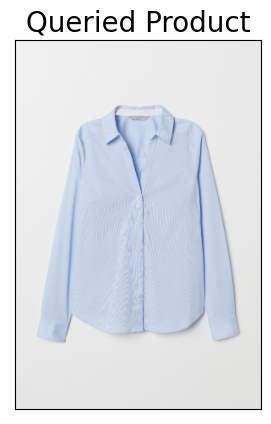

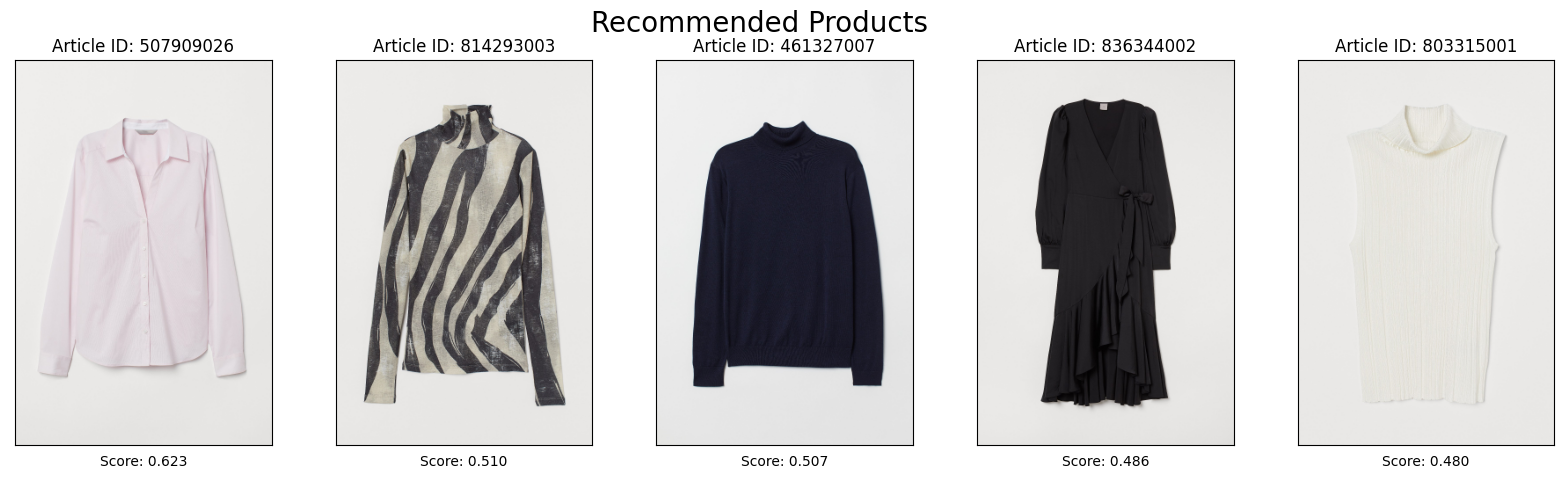

In [11]:
# Test recommender results
item_index_recommender(200, 5)

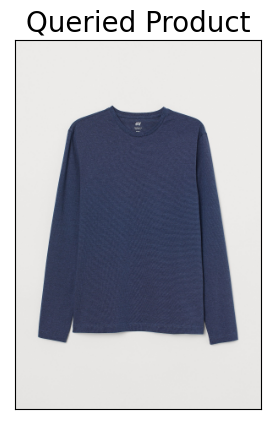

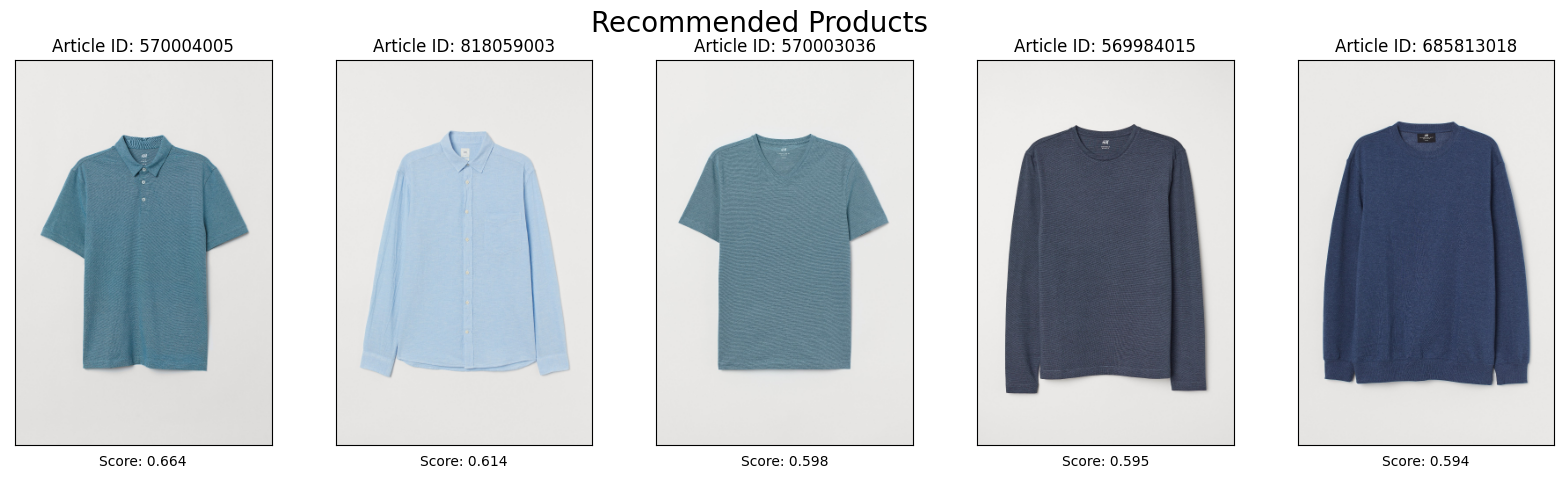

In [13]:
# Test recommender results
item_index_recommender(400, 5)

## Save Recommender Model

In [14]:
# https://github.com/benfred/implicit/issues/45
# 1. Save the indexes
model.recommend_index.saveIndex(filename='../streamlit/search_index',save_data=True)
model.similar_items_index.saveIndex(filename='../streamlit/similar_item_index',save_data=True)

# 2. Clear the indexes from model
model.recommend_index = None
model.similar_items_index = None

# 3. Save the model without indexes
pickle.dump(model, open('../streamlit/collaborative_filtering_model', 'wb'))

## Summary

- Collaborative-filtering recommender was built using customers' purchase history. 
- Given the large volumns of transaction data, **Alternating Least Square Matrix Factorisation** was used to reduce dimensionality of user-item matrix. **Hierarchical Navigable Small Worlds (HNSW)** was used to generate quick and reliable results for similarity search, by finding approximate nearest neighbours.

## Reference

1. https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26 <br>
2. https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe <br>
3. https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b <br>
4. https://andbloch.github.io/An-Overview-of-Collaborative-Filtering-Algorithms/
5. https://towardsdatascience.com/recsys-series-part-4-the-7-variants-of-matrix-factorization-for-collaborative-filtering-368754e4fab5